In [1]:
# General
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Classifying
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# kNN
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# SVM
from sklearn.svm import SVC
# Naive Bayes
from sklearn import naive_bayes

In [2]:
# https://www.pro-football-reference.com/years/2021/fantasy.htm
stats = pd.read_csv("football-positions.csv")
stats.head()

,Rk,Player,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,...,TD.3,2PM,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank
0,1,Jonathan Taylor*+\TaylJo02,IND,RB,22,17,17,0,0,0,...,20,NaN,NaN,333.0,373.1,381.1,353.1,187.0,1,1.0
1,2,Cooper Kupp*+\KuppCo00,LAR,WR,28,17,17,0,1,0,...,16,1.0,NaN,295.0,439.5,442.5,367.0,173.0,1,2.0
2,3,Deebo Samuel*+\SamuDe00,SFO,WR,25,16,15,1,2,24,...,14,NaN,NaN,262.0,339.0,347.0,300.5,140.0,2,3.0
3,4,Josh Allen\AlleJo02,BUF,QB,25,17,17,409,646,4407,...,6,2.0,1.0,403.0,402.6,426.6,417.6,134.0,1,4.0
4,5,Austin Ekeler\EkelAu00,LAC,RB,26,16,16,0,0,0,...,20,2.0,NaN,274.0,343.8,352.8,308.8,128.0,2,5.0


In [3]:
# Drop player name, team, and rank
# Drop fantasy columns that are not real stats
# Drop Y/R and Y/A because these are derivative of other stats
stats = stats.drop(["Rk", "Player", "Tm", "Y/A", "Y/R", "FantPt", "PPR", "DKPt", "FDPt", "VBD", "PosRank", "OvRank"], axis=1)

In [4]:
# Rename to position
stats.rename(columns = {'FantPos':'Pos'}, inplace = True)

In [5]:
# Check to see NA values
stats.isna().sum()

Pos       74
Age        0
G          0
GS         0
Cmp        0
Att        0
Yds        0
TD         0
Int        0
Att.1      0
Yds.1      0
TD.1       0
Tgt        0
Rec        0
Yds.2      0
TD.2       0
Fmb        0
FL         0
TD.3       0
2PM      604
2PP      638
dtype: int64

In [6]:
# Remove N/A position rows
stats.dropna(subset = ["Pos"], inplace=True)

In [7]:
# Replace N/A with 0 for 2PM and 2PP. 0 is what they actually are when nothing is listed in the original table
stats = stats. fillna(0)

## Classifying

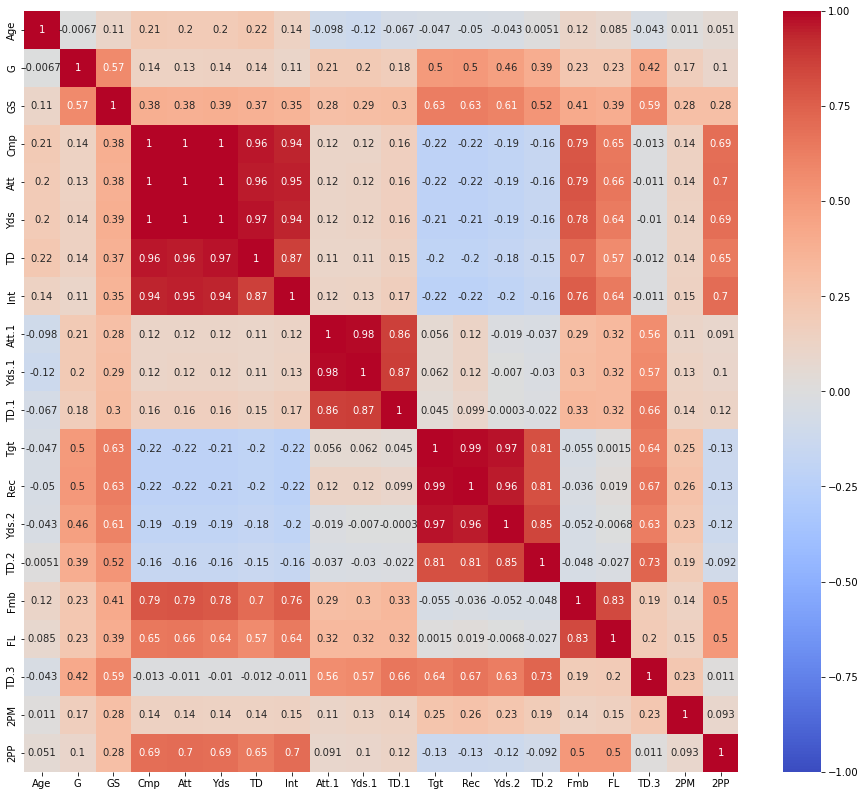

In [8]:
# Plot correlation
plt.figure(figsize=(16,14))
p=sns.heatmap(stats.corr(), annot=True, vmin=-1, vmax=1,cmap ="coolwarm")

In [9]:
# drop redundant columns
stats.drop(["Att", "Yds", "TD", "Int", "Yds.1", "TD.1", "Rec", "Yds.2", "TD.2", "FL"], axis=1)

,Pos,Age,G,GS,Cmp,Att.1,Tgt,Fmb,TD.3,2PM,2PP
0,RB,22,17,17,0,332,51,4,20,0.0,0.0
1,WR,28,17,17,0,4,191,0,16,1.0,0.0
2,WR,25,16,15,1,59,121,4,14,0.0,0.0
3,QB,25,17,17,409,122,0,8,6,2.0,1.0
4,RB,26,16,16,0,206,94,4,20,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
664,QB,26,5,0,0,6,0,0,0,0.0,0.0
666,RB,27,12,0,0,3,0,1,0,0.0,0.0
667,QB,26,3,0,1,2,0,0,0,0.0,0.0
668,QB,24,4,0,2,0,0,0,0,0.0,0.0


In [10]:
# Get X and y
X_unscaled = stats.drop(['Pos'], axis=1)
y = stats['Pos']
s = StandardScaler()
X = s.fit_transform(X_unscaled)

### PCA

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
WR = y=='WR'
TE = y=='TE'
RB = y=='RB'
QB = y=='QB'

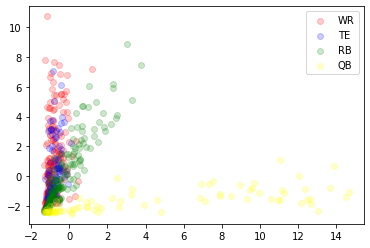

In [12]:
plt.scatter(X_pca[WR,0], X_pca[WR,1], label="WR", color="red", alpha=0.2)
plt.scatter(X_pca[TE,0], X_pca[TE,1], label="TE", color="blue", alpha=0.2)
plt.scatter(X_pca[RB,0], X_pca[RB,1], label="RB", color="green", alpha=0.2)
plt.scatter(X_pca[QB,0], X_pca[QB,1], label="QB", color="yellow", alpha=0.2)
plt.legend()

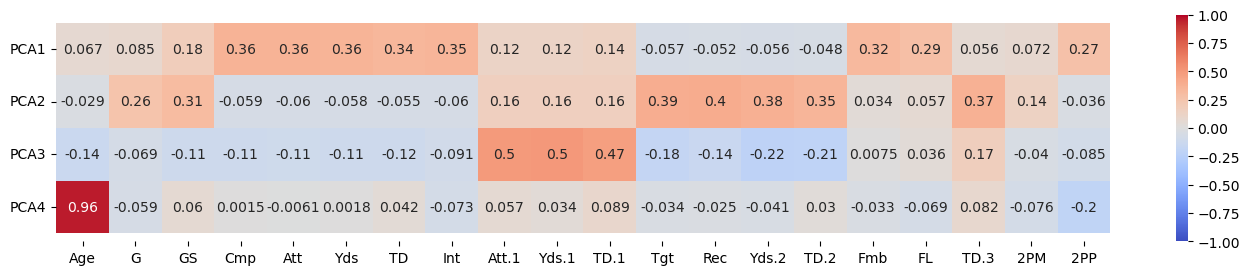

In [13]:
# Determine features importance (although we don't use feature selection)
pca = PCA(n_components=4)
x_new = pca.fit_transform(X)
fig= plt.figure(figsize=(17, 3),dpi=100)
ax = sns.heatmap(pca.components_,annot=True,cmap='coolwarm',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(X_unscaled.columns),vmin=-1,vmax=1)
plt.yticks(rotation=0);
ax.axis('equal');plt.show()

### tSNE

In [14]:
#compute TSNE
perplexity = 60
tsne = TSNE(random_state=0, perplexity=perplexity)
projected = tsne.fit_transform(X)  # project from 20 to 2 dimensions

In [15]:
#y

In [16]:
# replace position titles with integer values for plotting in next cell
positions = pd.unique(y)
#print(positions)
y_color = y.copy()
y_color.replace(to_replace=positions,
           value= list(range(len(positions))),
           inplace=True)

In [17]:
# ['RB' 'WR' 'QB' 'TE'] = [0, 1, 2, 3]
y.value_counts()

WR    227
RB    168
TE    118
QB     83
Name: Pos, dtype: int64

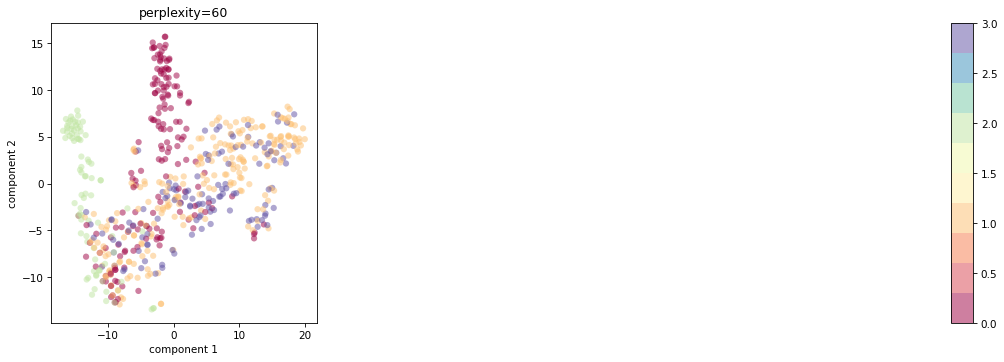

In [18]:
#plot TSNE projected data
fig = plt.figure(figsize = (15,5),dpi=75)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = fig.add_subplot(1, 3, 1)
im=ax.scatter(projected[:, 0], projected[:, 1],
            c=y_color , edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))  # Note: 'Spectral' must now be capitalized, unlike lowercase 'spectral' in text.
ax.set_title('perplexity=%d'%perplexity)
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.88,
                    wspace=0.15, hspace=0.02)
cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
plt.show()

In [19]:
# Split for testing
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 0,shuffle=True)

## kNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
# Find best k
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(kNN(), param_grid, verbose = 0, cv=3, scoring='accuracy');
grid.fit(X, y);
#
print('kNN best param = ',grid.best_params_)
kscoreM = grid.cv_results_['mean_test_score']
kscoreS = grid.cv_results_['std_test_score']
knnBest = grid.best_estimator_
k_cv = grid.best_params_['n_neighbors']

kNN best param =  {'n_neighbors': 19}


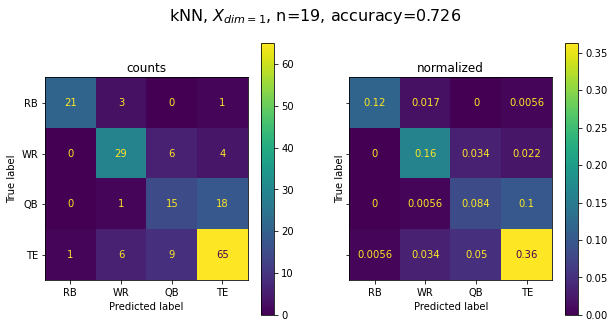

In [22]:
#plot confusion matrix
y_pred = knnBest.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
cmd = ConfusionMatrixDisplay(cm, display_labels=positions)
cmd.plot(ax=axes[0])
axes[0].set_title('counts')
cmd = ConfusionMatrixDisplay(cm/np.sum(cm[:]),display_labels=positions)
cmd.plot(ax=axes[1])
axes[1].set_title('normalized')
fig.suptitle('kNN, $X_{dim=1}$, n=19, accuracy=%2.3f'%(acc), fontsize=16);

### SVM

In [23]:
# defining parameter range 
param_grid = {'C': [70, 75, 80, 85], 
              'gamma': [0.000001, 0.00001, 0.0001,0.002,0.005,0.01],
              'kernel': ['linear', 'rbf']}  
grid = GridSearchCV(SVC(), param_grid, verbose = 0, cv=3, scoring='accuracy');
# fitting the model for grid search 
grid.fit(X, y);
svmBest = grid.best_estimator_
C_cv = grid.best_params_['C']
gamma_cv = grid.best_params_['gamma']
print(grid.best_estimator_) 

SVC(C=85, gamma=1e-06, kernel='linear')


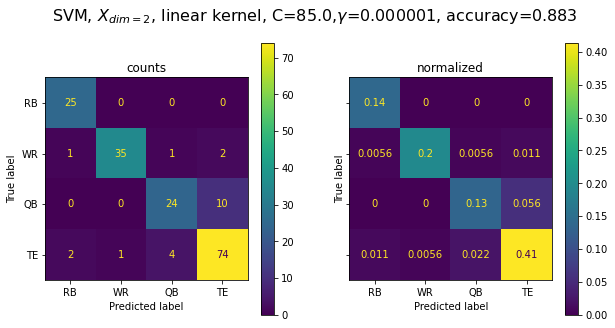

In [27]:
#plot confusion matrix
y_pred = svmBest.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
cmd = ConfusionMatrixDisplay(cm, display_labels=positions)
cmd.plot(ax=axes[0])
axes[0].set_title('counts')
cmd = ConfusionMatrixDisplay(cm/np.sum(cm[:]),display_labels=positions)
cmd.plot(ax=axes[1])
axes[1].set_title('normalized')
fig.suptitle(r'SVM, $X_{dim=2}$, linear kernel, C=%3.1f,$\gamma$=%3.6f, accuracy=%2.3f'%(C_cv,gamma_cv,acc), fontsize=16);

### Naive Bayes

In [25]:
#Naive Bayes classifier
gnb = naive_bayes.GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

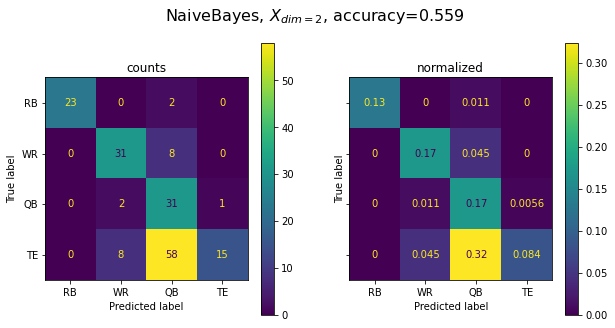

In [26]:
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
cmd = ConfusionMatrixDisplay(cm, display_labels=positions)
cmd.plot(ax=axes[0])
axes[0].set_title('counts')
cmd = ConfusionMatrixDisplay(cm/np.sum(cm[:]),display_labels=positions)
cmd.plot(ax=axes[1])
axes[1].set_title('normalized')
fig.suptitle('NaiveBayes, $X_{dim=2}$, accuracy=%2.3f'%acc, fontsize=16);